In [1]:
import csv
import time
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score, f1_score, precision_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, classification_report
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import nltk

nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')

import re

from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Load the dataset and remove invalid data

In [2]:
raw_data = pd.read_csv('categories.csv', sep = ';', header = None)
raw_data.columns = ["Text", "Class"]
raw_data.head(10)

,Text,Class
0,i feel lots of crypto has exhausted itself,1.0
1,How are you guys feeling today ??? :Bear: or ...,1.0
2,Did not take a trade today,1.0
3,Just entered eos long trade 👌,1.0
4,Anything good to buy now? Or did I miss it 😭,1.0
5,GL trading tonight guys. I'm off to eat dinne...,1.0
6,Okay my long position is still open on eth,1.0
7,morning guys any trades avaiable?,1.0
8,What’s everybodies thoughts today?,1.0
9,Are you guys more bullish or bearish for this ...,1.0


<Axes: >

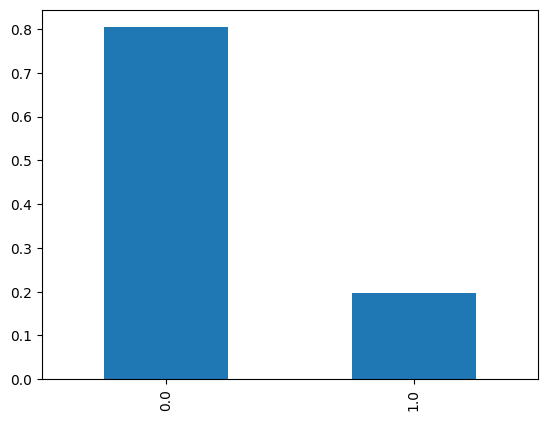

In [3]:
raw_data['Class'].value_counts(normalize = True).plot.bar()

## Data Preprocessing

In [4]:
lemmatizer = WordNetLemmatizer()
with open('specialWords.txt') as file:
    special_words = [line.strip() for line in file]

In [5]:
## cleaning text data, remove special charactors, numbers, puncatations, stopwords removing, lower casing, skip special words
cleaned_text = []
for idx in range(len(raw_data)):
    sentence = raw_data['Text'][idx]
    removeSpecialChars = str(sentence).translate ({ord(c): " " for c in "!@#$%^&*()[]{};:,./<>?\|`~-=_+"})
    pattern = r'[0-9]'
    new_string = re.sub(pattern, '', removeSpecialChars)
    new_string = re.sub(' +', ' ', new_string)
    new_string = ' '.join([word for word in new_string.split() if word not in stopwords.words("english")])
    new_string = ' '.join([lemmatizer.lemmatize(w).lower() if len(w)>1 and w not in special_words else w for w in new_string.split() ] )
    cleaned_text.append(new_string)

raw_data['cleaned_text'] = cleaned_text

In [6]:
raw_data.head(30)

,Text,Class,cleaned_text
0,i feel lots of crypto has exhausted itself,1.0,feel lot crypto exhausted
1,How are you guys feeling today ??? :Bear: or ...,1.0,how guy feeling today bear bull
2,Did not take a trade today,1.0,did take trade today
3,Just entered eos long trade 👌,1.0,just entered eos long trade 👌
4,Anything good to buy now? Or did I miss it 😭,1.0,anything good buy or I miss 😭
5,GL trading tonight guys. I'm off to eat dinne...,1.0,gl trading tonight guy i'm eat dinner 🙂 watch ...
6,Okay my long position is still open on eth,1.0,okay long position still open eth
7,morning guys any trades avaiable?,1.0,morning guy trade avaiable
8,What’s everybodies thoughts today?,1.0,what’s everybodies thought today
9,Are you guys more bullish or bearish for this ...,1.0,are guy bullish bearish week


**how many entries were dropped after pre-processing**

In [7]:
## drop missing rows
dropped_dataset=raw_data.dropna()
dropped_dataset['Class'] = dropped_dataset['Class'].astype(int)
print("Droped samples : ", len(raw_data) - len(dropped_dataset))

Droped samples :  513


## Data Sampling (Undersampling)

In [8]:
class_1_data = dropped_dataset[dropped_dataset["Class"] == 1]
class_0_data = dropped_dataset[dropped_dataset["Class"] == 0]

print("Samples of Class 0 : ", len(class_0_data.index))
print("Samples of Class 1 : ", len(class_1_data.index))

Samples of Class 0 :  23099
Samples of Class 1 :  5762


In [9]:
balanced_dataset = pd.concat([class_1_data, class_0_data.sample(len(class_1_data.index))], ignore_index=True)
print("Samples of Balanced Dataset : ", len(balanced_dataset.index))

Samples of Balanced Dataset :  11524


## Splitting into Train and Test

In [10]:
X = balanced_dataset['cleaned_text']
y = balanced_dataset['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, shuffle=True)

# **1. XGBoost Model**

In [11]:
xgb_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('xgb', xgb.XGBClassifier())
])
xgb_pipe.fit(X_train, y_train)
xgb_parameters = {
    'tvec__max_features':[1000, 2000],
    'tvec__max_df': (0.2, 0.6, 1.0),
    'tvec__min_df' : (1, 5, 10),
    'tvec__ngram_range': [(1, 1), (1, 2)],
    # 'tvec__norm' : ("l1", "l2"),
    'xgb__max_depth': range (2, 10, 4),
    'xgb__n_estimators': range(60, 220, 80),
    'xgb__learning_rate': [0.1, 0.01, 0.05]
}

In [13]:
# Setting up GridSearch for XGBoost
startTime = time.time()
xgb_gs = GridSearchCV(xgb_pipe, param_grid=xgb_parameters, cv = 3, verbose = 1, n_jobs = -1, scoring = 'roc_auc',)
xgb_gs.fit(X_train, y_train)
cpu_time = (time.time() - startTime)
print(cpu_time)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
1436.4490416049957


In [14]:
xgb_gs.best_params_

{'tvec__max_df': 0.6,
 'tvec__max_features': 2000,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 6,
 'xgb__n_estimators': 140}

In [15]:
xgb_gs.best_score_

0.9809774641221654

In [16]:
best_xgb = xgb_gs.best_estimator_

In [17]:
with open('{}.pkl'.format("best_xgb"),'wb') as f:
      pickle.dump(best_xgb,f)

# **2. SVM Classifier**

In [27]:
svc_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('svc', svm.SVC(probability= True))
])
svc_pipe.fit(X_train, y_train)
svc_parameters = {
    'tvec__max_features':[1000, 2000],
    'tvec__max_df': (0.2, 0.6, 1.0),
    'tvec__min_df' : (1, 5, 10),
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'svc__probability':[True],
    'svc__C':[1,10,100], #[1,10,100,1000]
    'svc__gamma':[1,0.1,0.01] #, [1,0.1,0.001,0.0001]
    # 'svc__kernel':['linear','rbf']
}

In [28]:
# Setting up GridSearch for SVC
startTime = time.time()
svc_gs = GridSearchCV(svc_pipe, param_grid=svc_parameters, cv = 3, verbose = 1, n_jobs = -1, scoring = 'roc_auc')
svc_gs.fit(X_train, y_train)
cpu_time = (time.time() - startTime)
print(cpu_time)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
7209.628829240799


In [29]:
svc_gs.best_params_

{'svc__C': 1,
 'svc__gamma': 1,
 'svc__probability': True,
 'tvec__max_df': 0.6,
 'tvec__max_features': 2000,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 2)}

In [30]:
svc_gs.best_score_

0.9866187394224211

In [31]:
best_svc = svc_gs.best_estimator_

In [32]:
with open('{}.pkl'.format("best_svc_prob"),'wb') as f:
      pickle.dump(best_svc,f)

In [33]:
with open('/content/drive/My Drive/models/{}.pkl'.format("best_svc_prob"),'wb') as f:
      pickle.dump(best_svc,f)

# **3. Random Forests**

In [24]:
from sklearn.ensemble import RandomForestClassifier
rf_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('rf', RandomForestClassifier())
])
rf_pipe.fit(X_train, y_train)
rf_parameters = {
    'tvec__max_features':[1000, 2000],
    'tvec__max_df': (0.2, 0.6, 1.0),
    'tvec__min_df' : (1, 5, 10),
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'rf__n_estimators': [200, 500],
    'rf__max_features': ['auto', 'sqrt'],
    'rf__max_depth' : [4,5,6]
    # 'rf__criterion' :['gini', 'entropy']
}

In [25]:
# Setting up GridSearch for XGBoost
startTime = time.time()
rf_gs = GridSearchCV(rf_pipe, param_grid=rf_parameters, cv = 3, verbose = 1, n_jobs = -1, scoring = 'roc_auc',)
rf_gs.fit(X_train, y_train)
cpu_time = (time.time() - startTime)
print(cpu_time)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
1416.313678264618


In [26]:
rf_gs.best_params_

{'rf__max_depth': 6,
 'rf__max_features': 'sqrt',
 'rf__n_estimators': 500,
 'tvec__max_df': 1.0,
 'tvec__max_features': 2000,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1)}

In [27]:
rf_gs.best_score_

0.9694649709215963

In [28]:
best_rf = rf_gs.best_estimator_

In [29]:
with open('{}.pkl'.format("best_rf"),'wb') as f:
      pickle.dump(best_rf,f)

In [30]:
with open('/content/drive/My Drive/models/{}.pkl'.format("best_rf"),'wb') as f:
      pickle.dump(best_rf,f)

# **4. Non-linear SVM**

In [36]:
nusvc_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('nusvc', svm.NuSVC(probability=True))
])
nusvc_pipe.fit(X_train, y_train)
nusvc_parameters = {
    'tvec__max_features':[1000, 2000],
    'tvec__max_df': (0.2, 0.6, 1.0),
    'tvec__min_df' : (1, 5, 10),
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'nusvc__probability':[True],
    'nusvc__nu':[0.5,1],
    'nusvc__gamma':[1,0.1]
}

In [37]:
# Setting up GridSearch for XGBoost
startTime = time.time()
nusvc_gs = GridSearchCV(nusvc_pipe, param_grid=nusvc_parameters, cv = 3, verbose = 1, n_jobs = -1, scoring = 'roc_auc',)
nusvc_gs.fit(X_train, y_train)
cpu_time = (time.time() - startTime)
print(cpu_time)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
2898.2522253990173


In [38]:
nusvc_gs.best_params_

{'nusvc__gamma': 1,
 'nusvc__nu': 0.5,
 'nusvc__probability': True,
 'tvec__max_df': 0.6,
 'tvec__max_features': 2000,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 2)}

In [39]:
nusvc_gs.best_score_

0.9830312656611153

In [40]:
best_nusvc = nusvc_gs.best_estimator_

In [41]:
with open('{}.pkl'.format("best_nusvc"),'wb') as f:
      pickle.dump(best_nusvc,f)

In [42]:
with open('/content/drive/My Drive/models/{}.pkl'.format("best_nusvc"),'wb') as f:
      pickle.dump(best_nusvc,f)

# **5. MLPClassifier**

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('mlp', MLPClassifier())
])
mlp_pipe.fit(X_train, y_train)
mlp_parameters = {
    'tvec__max_features':[1000, 2000],
    'tvec__max_df': (0.2, 0.6, 1.0),
    'tvec__min_df' : (1, 5, 10),
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'mlp__max_iter': [1000,2000],
    'mlp__hidden_layer_sizes':np.arange(10, 15)
}

In [ ]:
# Setting up GridSearch for XGBoost
startTime = time.time()
mlp_gs = GridSearchCV(mlp_pipe, param_grid=mlp_parameters, cv = 3, verbose = 1, n_jobs = -1, scoring = 'roc_auc',)
mlp_gs.fit(X_train, y_train)
cpu_time = (time.time() - startTime)
print(cpu_time)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits
14770.592341184616


In [ ]:
mlp_gs.best_params_

{'mlp__hidden_layer_sizes': 13,
 'mlp__max_iter': 1000,
 'tvec__max_df': 0.6,
 'tvec__max_features': 2000,
 'tvec__min_df': 10,
 'tvec__ngram_range': (1, 1)}

In [ ]:
mlp_gs.best_score_

0.9764208536752501

In [ ]:
best_mlp = mlp_gs.best_estimator_

In [ ]:
with open('{}.pkl'.format("best_mlp"),'wb') as f:
      pickle.dump(best_mlp,f)

In [ ]:
with open('/content/drive/My Drive/models/{}.pkl'.format("best_mlp"),'wb') as f:
      pickle.dump(best_mlp,f)

# **6. Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('lr', LogisticRegression())
])
lr_pipe.fit(X_train, y_train)
lr_parameters = {
    'tvec__max_features':[1000, 2000],
    'tvec__max_df': (0.2, 0.6, 1.0),
    'tvec__min_df' : (1, 5, 10),
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'lr__penalty': ['l1','l2'],
    'lr__C': [0.001,0.01,0.1,1,10,100,1000]
}

In [ ]:
# Setting up GridSearch for XGBoost
startTime = time.time()
lr_gs = GridSearchCV(lr_pipe, param_grid=lr_parameters, cv = 3, verbose = 1, n_jobs = -1, scoring = 'roc_auc',)
lr_gs.fit(X_train, y_train)
cpu_time = (time.time() - startTime)
print(cpu_time)

Fitting 3 folds for each of 504 candidates, totalling 1512 fits
242.89740991592407


In [ ]:
lr_gs.best_params_

{'lr__C': 10,
 'lr__penalty': 'l2',
 'tvec__max_df': 0.6,
 'tvec__max_features': 2000,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 2)}

In [ ]:
lr_gs.best_score_

0.9855399322272226

In [ ]:
best_lr = lr_gs.best_estimator_

In [ ]:
with open('{}.pkl'.format("best_lr"),'wb') as f:
      pickle.dump(best_lr,f)

In [ ]:
with open('/content/drive/My Drive/models/{}.pkl'.format("best_lr"),'wb') as f:
      pickle.dump(best_lr,f)

# **7. GradientBoosting**

In [43]:
from sklearn.ensemble import GradientBoostingClassifier

gb_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('gb', GradientBoostingClassifier())
])
gb_pipe.fit(X_train, y_train)
gb_parameters = {
    'tvec__max_features':[1000, 2000],
    'tvec__max_df': (0.2, 0.6, 1.0),
    'tvec__min_df' : (1, 5, 10),
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'gb__learning_rate': [0.01, 0.05, 0.1],
    'gb__max_depth': [3,5,8]
}

In [44]:
# Setting up GridSearch for XGBoost
startTime = time.time()
gb_gs = GridSearchCV(gb_pipe, param_grid=gb_parameters, cv = 3, verbose = 1, n_jobs = -1, scoring = 'roc_auc',)
gb_gs.fit(X_train, y_train)
cpu_time = (time.time() - startTime)
print(cpu_time)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
2155.7844705581665


In [45]:
gb_gs.best_params_

{'gb__learning_rate': 0.1,
 'gb__max_depth': 8,
 'tvec__max_df': 0.6,
 'tvec__max_features': 1000,
 'tvec__min_df': 5,
 'tvec__ngram_range': (1, 1)}

In [46]:
gb_gs.best_score_

0.9789127279771517

In [47]:
best_gb = gb_gs.best_estimator_

In [49]:
with open('{}.pkl'.format("best_gb"),'wb') as f:
      pickle.dump(best_gb,f)

In [50]:
with open('/content/drive/My Drive/models/{}.pkl'.format("best_gb"),'wb') as f:
      pickle.dump(best_gb,f)

# **Load the XGBoost model**

In [11]:
with open('{}.pkl'.format('best_xgb'),'rb') as c_f:
  best_xgb = pickle.load(c_f)

# **Load the SVC model**

In [12]:
with open('{}.pkl'.format('best_svc'),'rb') as c_f:
  best_svc = pickle.load(c_f)

# **Load the Random Forests model**

In [13]:
with open('{}.pkl'.format('best_rf'),'rb') as c_f:
  best_rf = pickle.load(c_f)

# **Load the MLP model**

In [14]:
with open('{}.pkl'.format('best_mlp'),'rb') as c_f:
  best_mlp = pickle.load(c_f)

# **Load the Non-linear SVM model**

In [15]:
with open('{}.pkl'.format('best_nusvc'),'rb') as c_f:
  best_nusvc = pickle.load(c_f)

# **Load the Logistic Regression model**

In [16]:
with open('{}.pkl'.format('best_lr'),'rb') as c_f:
  best_lr = pickle.load(c_f)

# **Load the GradientBoosting model**

In [17]:
with open('{}.pkl'.format('best_gb'),'rb') as c_f:
  best_gb = pickle.load(c_f)

In [18]:
def plot_roc_curve(models, X_test):
  plt.figure(0).clf()
  for model_name in models:
    y_pred = models[model_name].predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = round(roc_auc_score(y_test, y_pred), 4)
    plt.plot(fpr,tpr,label="{}, AUC={}".format(model_name, round(auc, 4)))
  plt.legend()

In [19]:
def plot_precision_recall_curve(models, X_test):
  plt.figure(0).clf()

  for model_name in models:
    y_proba = models[model_name].predict_proba(X_test)[:, 1]
    y_pred = models[model_name].predict(X_test)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_proba)
    lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)
    plt.plot(lr_precision,lr_recall,label="{}, AUC={}".format(model_name, round(lr_auc, 4)))
  plt.legend()

In [20]:
## build a function to evaluate classification model
def model_evaluation(model, train, test, train_y, test_y):
    pred_train = model.predict(train)
    pred_test = model.predict(test)

    print(classification_report(test_y, pred_test))
    train_acc = accuracy_score(pred_train,train_y)
    test_acc = accuracy_score(pred_test,test_y)

    train_recall = recall_score(train_y,pred_train, average = 'weighted')
    test_recall = recall_score(test_y,pred_test, average = 'weighted')

    train_precision = precision_score(train_y,pred_train, average = 'weighted')
    test_precision = precision_score(test_y,pred_test, average = 'weighted')

    train_f1 = f1_score(train_y,pred_train, average = 'weighted')
    test_f1 = f1_score(test_y,pred_test, average = 'weighted')

    print("\n\t\t  Train score  /  Test score\n")
    print(f"Accuracy  : {train_acc} / {test_acc}")
    print(f"Recall    : {train_recall} / {test_recall}")
    print(f"Precision : {train_precision} / {test_precision}")
    print(f"F1 Score  : {train_f1} / {test_f1}")

    cm=confusion_matrix(test_y, pred_test)
    FP = cm[0][1]
    df_cm = pd.DataFrame(cm, index = [i for i in ['class:  0', 'class : 1']],
                  columns = [i for i in ['class:  0', 'class : 1']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (8,4))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.title("\nConfusion Matrix\n", color='blue', fontsize = 16)
    plt.ylabel('\nActual\n', color='blue')
    plt.xlabel('\nPredicted\n', color = 'blue')
    plt.show()
    return [test_acc, test_recall, test_precision, test_f1], FP

In [21]:
models = {}
models["XGBoost"] = best_xgb
models["SVM Classifier"] = best_svc
models["Random Forests"] = best_rf
models["Non-linear SVM"] = best_nusvc
models["MLPClassifier"] = best_mlp
models["Logistic Regression"] = best_lr
models["GradientBoosting"] = best_gb


# **Plot ROC Curve**

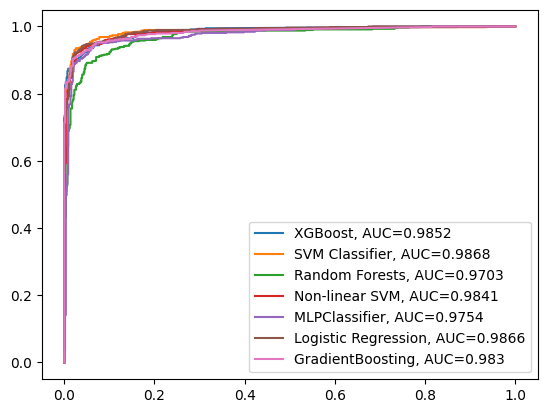

In [22]:
plot_roc_curve(models, X_test)

# **Plot PR Curve**

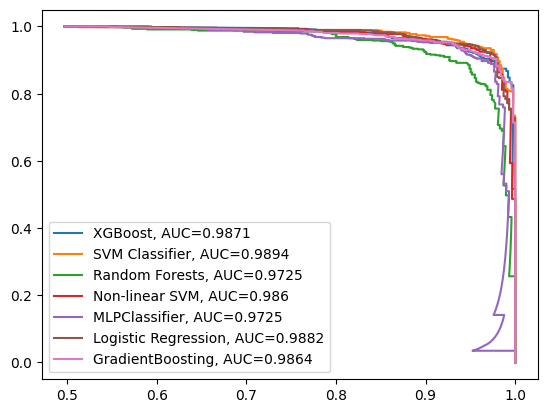

In [23]:
plot_precision_recall_curve(models, X_test)

# **Plot Model Evaluation**

In [29]:
scores_data = {}
FPs = {}


			XGBoost

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       580
           1       0.96      0.92      0.94       573

    accuracy                           0.94      1153
   macro avg       0.94      0.94      0.94      1153
weighted avg       0.94      0.94      0.94      1153


		  Train score  /  Test score

Accuracy  : 0.9529457140102208 / 0.9401561144839549
Recall    : 0.9529457140102208 / 0.9401561144839549
Precision : 0.9529951687610584 / 0.9407279582735991
F1 Score  : 0.9529446036639033 / 0.940129629806425


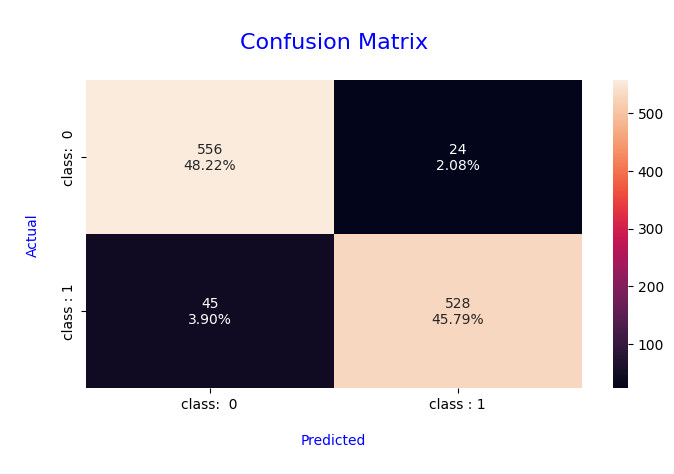


			SVM Classifier

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       580
           1       0.96      0.94      0.95       573

    accuracy                           0.95      1153
   macro avg       0.95      0.95      0.95      1153
weighted avg       0.95      0.95      0.95      1153


		  Train score  /  Test score

Accuracy  : 0.9750265162472278 / 0.9496964440589766
Recall    : 0.9750265162472278 / 0.9496964440589766
Precision : 0.9751104158613844 / 0.9498850657847648
F1 Score  : 0.9750252985933192 / 0.9496878144152358


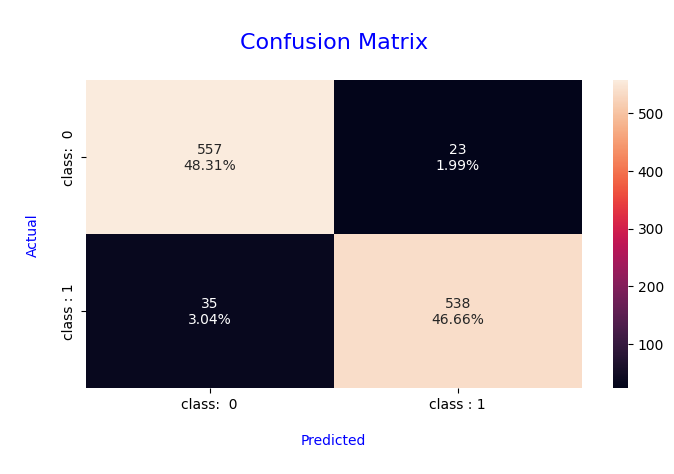


			Random Forests

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       580
           1       0.95      0.86      0.91       573

    accuracy                           0.91      1153
   macro avg       0.91      0.91      0.91      1153
weighted avg       0.91      0.91      0.91      1153


		  Train score  /  Test score

Accuracy  : 0.9191977629929612 / 0.9106678230702515
Recall    : 0.9191977629929612 / 0.9106678230702515
Precision : 0.9210977837624424 / 0.914122054435496
F1 Score  : 0.919108517660799 / 0.9104535566694074


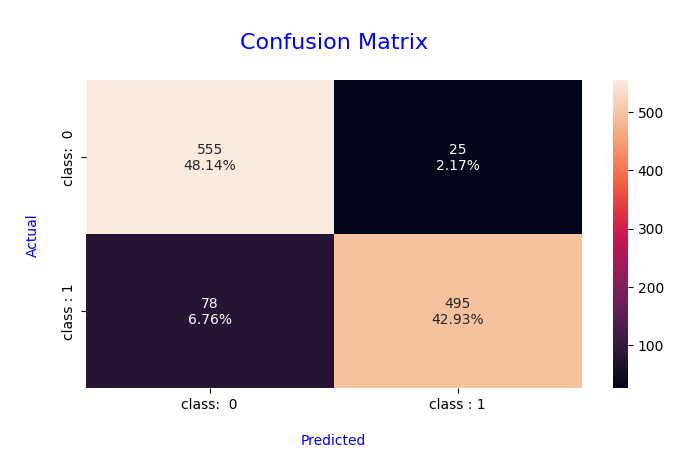


			Non-linear SVM

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       580
           1       0.97      0.92      0.94       573

    accuracy                           0.95      1153
   macro avg       0.95      0.95      0.95      1153
weighted avg       0.95      0.95      0.95      1153


		  Train score  /  Test score

Accuracy  : 0.948510269019381 / 0.9462272333044233
Recall    : 0.948510269019381 / 0.9462272333044233
Precision : 0.9488383589333 / 0.9469887321583931
F1 Score  : 0.948501353832299 / 0.9461971177572424


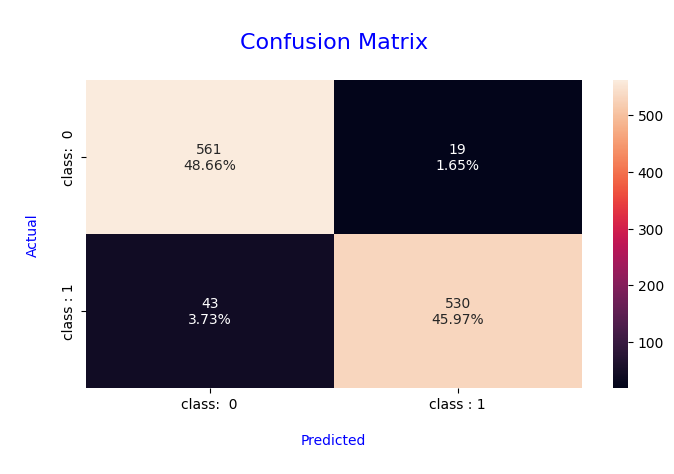


			MLPClassifier

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       580
           1       0.94      0.92      0.93       573

    accuracy                           0.93      1153
   macro avg       0.94      0.93      0.93      1153
weighted avg       0.94      0.93      0.93      1153


		  Train score  /  Test score

Accuracy  : 0.9748336708128436 / 0.9349522983521249
Recall    : 0.9748336708128436 / 0.9349522983521249
Precision : 0.9754252107801076 / 0.9351647389326974
F1 Score  : 0.9748255325992569 / 0.9349395727780855


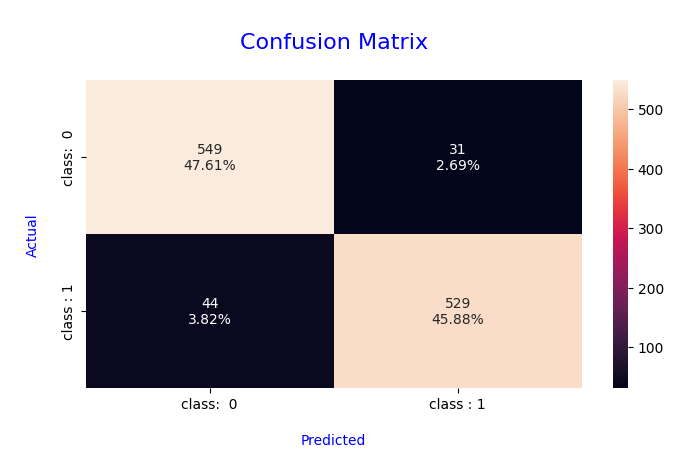


			Logistic Regression

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       580
           1       0.96      0.94      0.95       573

    accuracy                           0.95      1153
   macro avg       0.95      0.95      0.95      1153
weighted avg       0.95      0.95      0.95      1153


		  Train score  /  Test score

Accuracy  : 0.9684697714781603 / 0.9505637467476149
Recall    : 0.9684697714781603 / 0.9505637467476149
Precision : 0.9686074504147629 / 0.9507221576610381
F1 Score  : 0.9684672666132819 / 0.9505563819980737


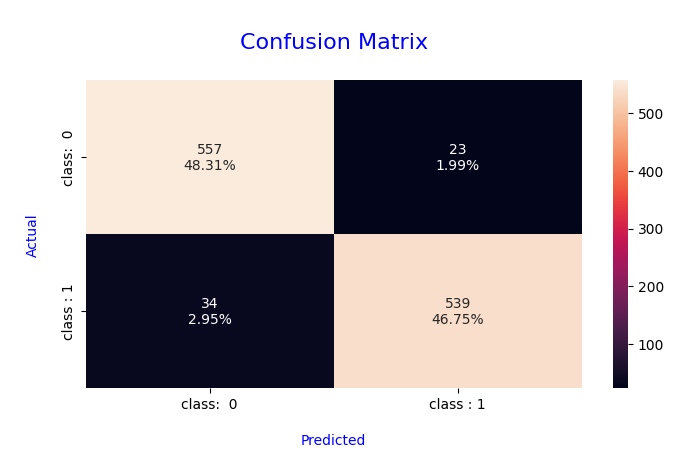


			GradientBoosting

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       580
           1       0.95      0.92      0.94       573

    accuracy                           0.94      1153
   macro avg       0.94      0.94      0.94      1153
weighted avg       0.94      0.94      0.94      1153


		  Train score  /  Test score

Accuracy  : 0.9622987175778613 / 0.9392888117953165
Recall    : 0.9622987175778613 / 0.9392888117953165
Precision : 0.9623036028897707 / 0.9398055861821272
F1 Score  : 0.9622985745642599 / 0.9392641376513311


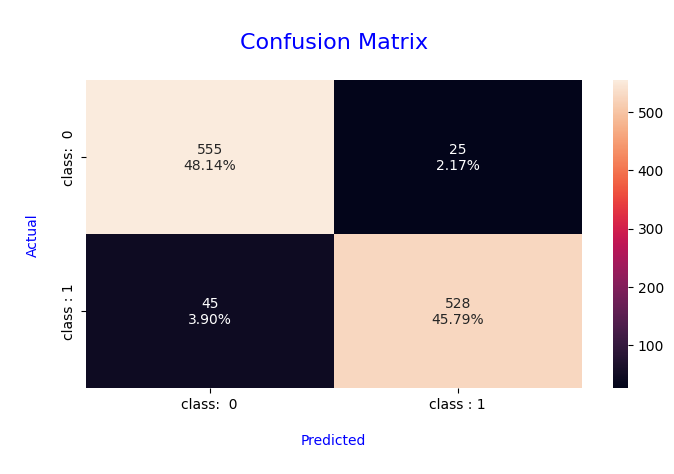

In [30]:

for model_name in models:
  print('\n\t\t\t{}\n'.format(model_name))
  score, FP = model_evaluation(models[model_name], X_train, X_test, y_train, y_test)
  scores_data[model_name] = score
  FPs[model_name] = FP

In [31]:
score_df = pd.DataFrame(scores_data).T
score_df.columns = ['accuracy', 'recall', 'precision', 'f1-score']
score_df

,accuracy,recall,precision,f1-score
XGBoost,0.940156,0.940156,0.940728,0.940130
SVM Classifier,0.949696,0.949696,0.949885,0.949688
Random Forests,0.910668,0.910668,0.914122,0.910454
Non-linear SVM,0.946227,0.946227,0.946989,0.946197
MLPClassifier,0.934952,0.934952,0.935165,0.934940
Logistic Regression,0.950564,0.950564,0.950722,0.950556
GradientBoosting,0.939289,0.939289,0.939806,0.939264


In [32]:
FP_df = pd.DataFrame.from_dict(FPs, orient='index', columns = ["FP"])
FP_df

,FP
XGBoost,24
SVM Classifier,23
Random Forests,25
Non-linear SVM,19
MLPClassifier,31
Logistic Regression,23
GradientBoosting,25


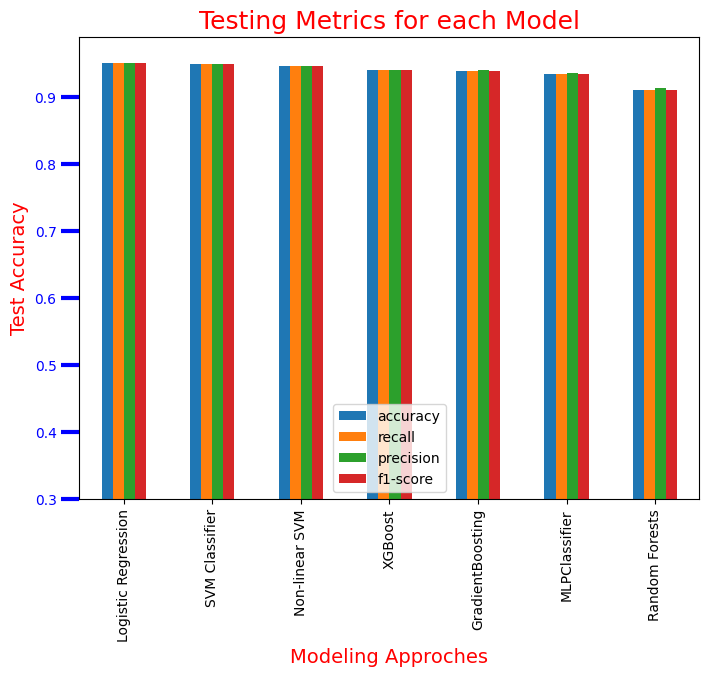

In [33]:
score_df.sort_values('accuracy',ascending = False).plot(kind='bar',figsize=(8,6))
plt.title("Testing Metrics for each Model",fontsize=18,color='red')
plt.tick_params(axis='y', colors='blue', direction='out', length=13, width=3)
plt.xlabel("Modeling Approches", fontsize=14, color = 'red')
plt.ylim([0.3, 0.99])
plt.ylabel("Test Accuracy", fontsize=14, color = 'red')
plt.show()

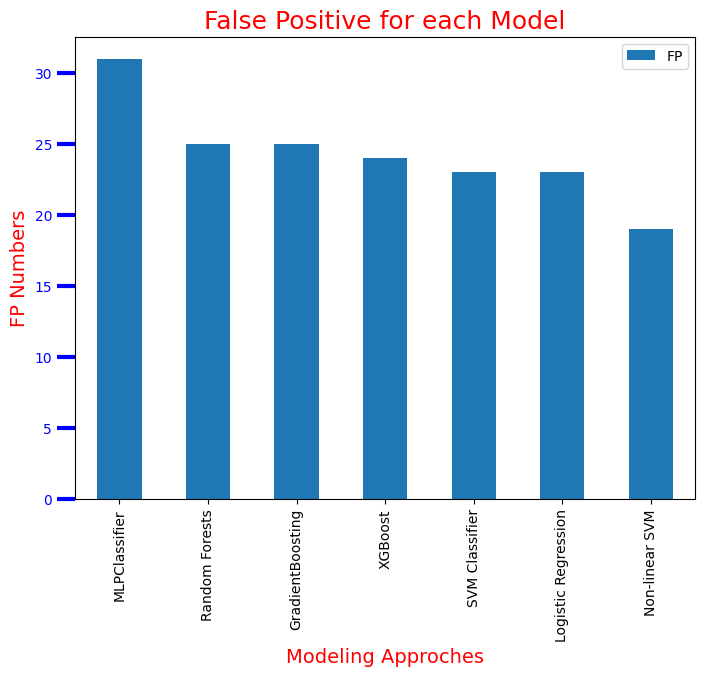

In [34]:
FP_df.sort_values('FP',ascending = False).plot(kind='bar',figsize=(8,6))
plt.title("False Positive for each Model",fontsize=18,color='red')
plt.tick_params(axis='y', colors='blue', direction='out', length=13, width=3)
plt.xlabel("Modeling Approches", fontsize=14, color = 'red')
plt.ylabel("FP Numbers", fontsize=14, color = 'red')
plt.show()